In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, classification_report, 
                             confusion_matrix, roc_auc_score)
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter

In [2]:
# load the preprocessed data
data = pd.read_csv('Cleaned_data_53v_Final.csv')

In [3]:
X = data.drop(columns=['target'])
y = data['target']

In [4]:
# class distribution before resampling
target_counts = y.value_counts()
sizes = [target_counts[0], target_counts[1]]

target_counts

target
0    315449
1     78624
Name: count, dtype: int64

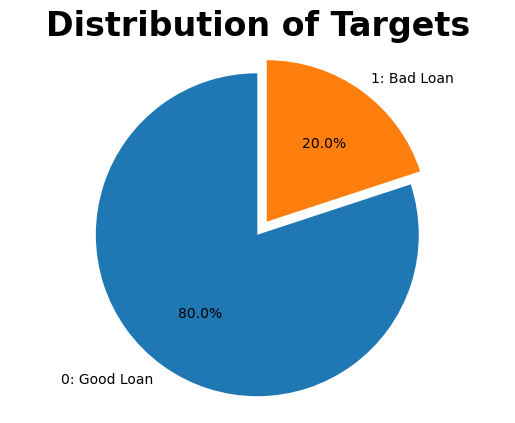

In [5]:
fig, ax = plt.subplots()
ax.pie(sizes, labels=['0: Good Loan', '1: Bad Loan'], autopct='%1.1f%%', startangle=90, explode=(0, 0.1))
ax.axis('equal')
plt.title('Distribution of Targets', fontsize=24, fontweight='bold')
plt.show()

## Class Imbalance Handling Techniques

### Sampling Techniques

In [6]:
# https://imbalanced-learn.org/stable/over_sampling.html
# https://imbalanced-learn.org/stable/under_sampling.html
# https://imbalanced-learn.org/stable/combine.html
sampling_techniques = {
    'None': (None, None),
    'ROS': (RandomOverSampler(random_state=42), "Over"),
    'SMOTE': (SMOTE(random_state=42), "Over"),
    'ADASYN': (ADASYN(random_state=42), "Over"),
    'RUS': (RandomUnderSampler(random_state=42), "Under"),
    'Tomek-Links': (TomekLinks(), "Under"),
    'SMOTE-Tomek': (SMOTETomek(random_state=42), "Combine"),
    'SMOTE+ENN': (SMOTEENN(sampling_strategy='minority',random_state=42), "Combine")
    # sampling strategy 'minority'means resample only the minority class
}

### Result

In [7]:
results = []

for name, (technique, type) in sampling_techniques.items():
    print("\nSampling Technique: ",name)

    # resample the data
    if technique is not None:
        X_resampled, y_resampled = technique.fit_resample(X, y)
    else:
        X_resampled, y_resampled = X, y

    dist = Counter(y_resampled)
    print("Class distribution after resampling: ", dist)
    
    # split the balanced data
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.20, random_state=42)

    model = XGBClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))

    # model evaluation
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)

    results.append({
        'Method': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'AUC-ROC': auc_roc
    })


Sampling Technique:  None
Class distribution after resampling:  Counter({0: 315449, 1: 78624})
              precision    recall  f1-score   support

           0       0.82      0.98      0.89     63192
           1       0.54      0.11      0.18     15623

    accuracy                           0.80     78815
   macro avg       0.68      0.54      0.54     78815
weighted avg       0.76      0.80      0.75     78815


Sampling Technique:  ROS
Class distribution after resampling:  Counter({0: 315449, 1: 315449})
              precision    recall  f1-score   support

           0       0.69      0.67      0.68     63084
           1       0.68      0.71      0.69     63096

    accuracy                           0.69    126180
   macro avg       0.69      0.69      0.69    126180
weighted avg       0.69      0.69      0.69    126180


Sampling Technique:  SMOTE
Class distribution after resampling:  Counter({0: 315449, 1: 315449})
              precision    recall  f1-score   support

 

In [8]:
samp_results = pd.DataFrame(results)
samp_results

,Method,Accuracy,Precision,Recall,AUC-ROC
0,None,0.804720,0.536160,0.110094,0.717113
1,ROS,0.687391,0.680650,0.706162,0.755934
2,SMOTE,0.876613,0.968366,0.778686,0.928387
3,ADASYN,0.874526,0.968555,0.769030,0.926556
4,RUS,0.650048,0.646468,0.668335,0.707898
5,Tomek-Links,0.794680,0.536754,0.137687,0.719695
6,SMOTE-Tomek,0.876214,0.967913,0.777889,0.929491
7,SMOTE+ENN,0.904870,0.946113,0.920232,0.965390


## Training Split to choose

In [18]:
# declare XGBoost, and test_size
model = XGBClassifier() 
data_split = [], sizes = [0.20, 0.25, 0.30, 0.35, 0.40]

In [22]:
# function to calculate the performance metrics used in this project
def performance_metrics(y_true, y_pred, y_prob, size):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    
    data_split.append({'Test Size': size, 'Accuracy': accuracy, 
                       'Precision': precision, 
                       'Recall': recall, 'AUC': auc})

In [25]:
# test the different test ratios and append result to the list
for size in sizes:
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=size, random_state=42)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]

    performance_metrics(y_test, y_test_pred, y_test_prob, size)

In [26]:
ratio = pd.DataFrame(data_split)
ratio

,Test Size,Accuracy,Precision,Recall,AUC
0,0.20,0.904870,0.946113,0.920232,0.965390
1,0.25,0.903256,0.943461,0.920673,0.965105
2,0.30,0.904019,0.945253,0.919943,0.965216
3,0.35,0.903335,0.944648,0.919718,0.965311
4,0.40,0.903636,0.944510,0.920203,0.965050


In [27]:
ratio[['Accuracy', 'Precision', 'Recall', 'AUC']].max()

Accuracy     0.904870
Precision    0.946113
Recall       0.920673
AUC          0.965390
dtype: float64